In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH_455_GDRIVE = './drive/Shareddrives/CSE455 Final Project'
FORMATTED_DATA_PATH_GDRIVE = './drive/Shareddrives/CSE455 Final Project/balanced_formatted_data'
FACE_DETECTION_PATH_GDRIVE = PATH_455_GDRIVE + '/face-detection-pytorch-master/'
TAR_DATA_PATH = PATH_455_GDRIVE + '/balanced_formatted_data.tar'

Mounted at /content/drive


# Initialize

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import random
import os
import shutil
import seaborn as sns
import pandas as pd
import time

from torch.utils.data import SubsetRandomSampler
from torch.optim import lr_scheduler
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage import exposure
from skimage.util import random_noise
from PIL import Image

os.chdir(FACE_DETECTION_PATH_GDRIVE)
from detectors import FaceBoxes
from utils import draw_bboxes, crop_thumbnail, draw_bbox

# load detector with device(cpu or cuda)
DET = FaceBoxes(device='cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.chdir('/content/')
print(device)

[FaceBoxes] loading with cuda
[FaceBoxes] finished loading (11.6617 sec)
cuda:0


In [ ]:
"""
  Copy the data to colab
"""
def copy_data():
  if not os.path.exists('balanced_formatted_data'):
    if not os.path.exists(TAR_DATA_PATH):
      print("Can't find the tar file.. Please upload the tar file to google drive")
      return
    print("Copying to Colab's local drive..")
    shutil.copy(TAR_DATA_PATH, './data.tar')
    print("Uncompressing..")
    !tar --exclude='._*' -xf data.tar # mac generates ._ files
    
  print("Data ready!!")

copy_data()

Copying to Colab's local drive..
Uncompressing..
Data ready!!


In [ ]:
"""
  Data loader for all models
"""
def get_data():
    
  # load the image from formatted data folder
  
  normalize = transforms.Normalize([0.485, 0.456, 0.406], 
                                   [0.229, 0.224, 0.225])
  
  transform_resnet = transforms.Compose(
      [transforms.Resize(256), 
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize])
  
  transform_incep = transforms.Compose(
        [transforms.Resize(size=325), 
         transforms.CenterCrop(299),
         transforms.ToTensor(),
         normalize])
  
  transform_darknet = transforms.Compose(
        [transforms.Resize(size=(256, 256)), 
        transforms.ToTensor(),
        normalize])
  
  test_resnet = torchvision.datasets.ImageFolder(
      root='./balanced_formatted_data/test/',
      transform=transform_resnet)
  
  test_incep = torchvision.datasets.ImageFolder(
      root='./balanced_formatted_data/test/',
      transform=transform_incep)
  
  test_dark = torchvision.datasets.ImageFolder(
      root='./balanced_formatted_data/test/',
      transform=transform_darknet)


  # creating data loader for each set
  testLoader_resnet = torch.utils.data.DataLoader(test_resnet, 
                                            batch_size=32, 
                                            shuffle=False,
                                            num_workers=2,
                                            )
  
  testLoader_incep = torch.utils.data.DataLoader(test_incep, 
                                            batch_size=32, 
                                            shuffle=False,
                                            num_workers=2,
                                            )
  
  testLoader_dark = torch.utils.data.DataLoader(test_dark, 
                                            batch_size=32, 
                                            shuffle=False,
                                            num_workers=2,
                                            )
  
  # creating classes and idx2class
  # classes = [None for i in range(6)]
  idx2class = {}

  for k, v in test_incep.class_to_idx.items():
    idx2class[v] = k

  print(idx2class)

  return {'test_resnet': testLoader_resnet, 
          'test_inception': testLoader_incep,
          'test_darknet': testLoader_dark,
          'idx2class': idx2class}

data = get_data()

{0: 'AgnezMo', 1: 'Justin-Bieber', 2: 'Mallory', 3: 'Other', 4: 'Raven-Samone', 5: 'Sanchit'}


In [ ]:
"""
Displaying the image
"""
def imshow(img):
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()

def viz_data(data):
  dataiter = iter(data['train'])
  images, labels = dataiter.next()
  print(images.size())

  # show images
  imshow(torchvision.utils.make_grid(images[:8]))
  # print labels
  print("Labels:" + ' '.join(
      '%2s' % data['classes'][labels[j]] for j in range(8)))

  flat = torch.flatten(images, 1)
  print(images.size())
  print(flat.size())

In [ ]:
"""
  Calculating the models's accuracy
"""
def accuracy(model, dataloader):
  model.to(device)
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for batch in dataloader:
      images, labels = batch[0].to(device), batch[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  
  return correct / total

"""
  Smoothing the image for visualization
"""
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

## Inception

In [ ]:
# load inception
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/inception_new_small_batch.pt'

inception_v3 = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', 
                              pretrained=True)

# change the last layer
# aux net
num_ftrs = inception_v3.AuxLogits.fc.in_features
inception_v3.AuxLogits.fc = nn.Linear(num_ftrs, 6)  # we have 6 classes
  # primary net
num_ftrs = inception_v3.fc.in_features
inception_v3.fc = nn.Linear(num_ftrs, 6)  # we have 6 classes

inception_v3.load_state_dict(torch.load(model_save_path, 
                                        map_location=torch.device(device)))
inception_v3.eval()
inception_v3.to(device)
inception_model = (inception_v3, 'inception')

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


## Resnet

In [ ]:
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/resnet152_new.pt'

resnet152 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', 
                           pretrained=True)

# change the final layer
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, 6) 

resnet152.load_state_dict(torch.load(model_save_path, 
                                     map_location=torch.device(device)))
resnet152.eval()
resnet152.to(device)
resnet_model = (resnet152, 'resnet')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


## DarkNet

In [ ]:
class Darknet256(nn.Module):
    def __init__(self):
        super(Darknet256, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512, 6)
        # self.fc2 = nn.Linear(256, 6)
        self.dropout = nn.Dropout(0.5) # drop out 30% chance

    def forward(self, x):
        # Input 256x256x3

        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 
                         kernel_size=2, stride=2) # 128x128x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 
                         kernel_size=2, stride=2) # 64x64x32
        # x = self.dropout(x)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 
                         kernel_size=2, stride=2) # 32x32x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), 
                         kernel_size=2, stride=2) # 16x16x128
        x = self.dropout(x)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), 
                         kernel_size=2, stride=2) # 8x8x256
        x = F.max_pool2d(F.relu(self.bn6(self.conv6(x))), 
                         kernel_size=2, stride=2) # 4 x 4 x 512       

        # Global average pooling across each channel
        x = F.adaptive_avg_pool2d(x, 1) # 1x1x512
        x = torch.flatten(x, 1)         # vector 512
        
        x = self.fc1(x)
        # x = self.fc2(x)
        return x

# Load the model
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/darknet256_new.pt'

darknet256 = Darknet256()
darknet256.load_state_dict(torch.load(model_save_path))
darknet256.eval()
darknet256.to(device)

Darknet256(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (

## VGG

In [ ]:
class Vgg_face_dag(nn.Module):

    def __init__(self):
        super(Vgg_face_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=6, bias=True)

    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        return x38

# load the model
model_save_path = PATH_455_GDRIVE + '/model-checkpoint/vgg_new.pt'

vgg = Vgg_face_dag()

vgg.load_state_dict(torch.load(model_save_path))
vgg.eval()
vgg.to(device)

Vgg_face_dag(
  (conv1_1): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace=True)
  (pool3)

In [ ]:
import urllib.request

def cropped_im(image_path, verbose=True):
  if 'https://' in image_path:
    with urllib.request.urlopen(image_path) as url:
      s = url.read()
      arr = np.asarray(bytearray(s), dtype=np.uint8)
      img = cv2.imdecode(arr, -1) # 'Load it as it is'
  else:
    img = cv2.imread(image_path)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
  # DSFD returns bboxes.
  bboxes = DET.detect_faces(img, conf_th=0.9)

  # crop thumbnail from original image.
  results = []
  for i, bbox in enumerate(bboxes):
      thumb_img, _ = crop_thumbnail(img, bbox, padding=1, size=100)
      thumb_img = Image.fromarray(thumb_img) # convert to PIL image
      results.append(thumb_img)

  if not results:
    bboxes = DET.detect_faces(img, conf_th=0.65)

    for i, bbox in enumerate(bboxes):
      thumb_img, _ = crop_thumbnail(img, bbox, padding=1, size=100)
      thumb_img = Image.fromarray(thumb_img) # convert to PIL image
      results.append(thumb_img)

  # plot results
  # plot original image
  if verbose:
    grid = plt.GridSpec(2, len(results))
    plt.subplot(grid[0, 0:]).imshow(img)
    plt.show()

  return results if results else img


def predict_pics(model_data, image_path, idx2class, k=3):
  image_list = cropped_im(image_path)
  model = model_data[0]
  results = []
  normalize = transforms.Normalize([0.485, 0.456, 0.406], 
                                   [0.229, 0.224, 0.225])
  transform = transforms.Compose([transforms.Resize(size=(256, 256)), 
                                    transforms.ToTensor()])

  for i in range(len(image_list)):
    image = image_list[i]
    im_disp = transform(image)
    imshow(torchvision.utils.make_grid(im_disp))
    for model_tup in model_data:
      model, model_name = model_tup[0], model_tup[1]
      
      transform_norm = transforms.Compose([transforms.Resize(size=325), 
                                    transforms.CenterCrop(299),
                                    transforms.ToTensor(),
                                    normalize])
      
      # if model_name == 'inception':
      #   transform_norm = transforms.Compose([transforms.Resize(size=325), 
      #                               transforms.CenterCrop(299),
      #                               transforms.ToTensor(),
      #                               normalize])
      # elif model_name == 'darknet':
      #   transform_norm = transforms.Compose([transforms.Resize(size=(256, 256)), 
      #                               transforms.ToTensor(),
      #                               normalize])
      # elif model_name == 'resnet':
      #   transform_norm = transforms.Compose(
      #       [transforms.Resize(256), 
      #        transforms.CenterCrop(224),
      #        transforms.ToTensor(),
      #        normalize])
    
      image_transform = transform_norm(image)
      image_transform = image_transform.to(device)
      outputs = model(image_transform[None, ...]) # predict
      _, predicted = torch.max(outputs.data, 1) 
      predicted_name = idx2class[predicted.item()]
      _, topK_names = torch.topk(outputs, k, dim=1)
      print("{} prediction:".format(model_name))
      print("This is {}".format(predicted_name))
      # print(topK_names[1][0])
      topK_list = []
      for i in topK_names[0]:
        topK_list.append(idx2class[i.item()])
      print("Top {} names: {}".format(k, topK_list))
      results.append(predicted_name)
      print()

  return results

# Eval with topK

Inception top K result: `[0.7764, 0.9090, 0.9514]` </br>
Resnet top k result: `[0.7597, 0.8785, 0.9417]` </br>
Darknet top k result: `[0.5472, 0.7708, 0.8847]` </br>
VGG top K result: `[0.6438, 0.7785, 0.9153]`


In [ ]:
"""
  Calculating the models's top-k accuracy
"""
def accuracy(model, dataloader, k=1):
  model.to(device)
  model.eval()
  correct = 0
  total = 0
  results = torch.zeros(k)

  with torch.no_grad():
    for batch in dataloader:
      images, labels = batch[0].to(device), batch[1].to(device)
      outputs = model(images)
      _, topK_idx = torch.topk(outputs, k, dim=1)
      predicteds = []
      total += labels.size(0)
      print("process output for batch {}".format(total/labels.size(0)))
      # print(topK_idx)
      # print(labels)
      # print(labels in topK_idx[0])
      for i in range(labels.size(0)):
        # print("label: {} -- pred: {}".format(labels[i].item(), 
        #                                      topK_idx[i]))
        for j in range(k):
          if labels[i].item() in topK_idx[i][:j+1]:
            # print('true')
            results[j] += 1

      # correct += (predicted == labels).sum().item()
  
  return results / total

In [ ]:
k = 3
res = accuracy(vgg, data['test_resnet'], k) 
print("Test accuracy for top {}: {}".format(k, res))

process output for batch 1.0
process output for batch 2.0
process output for batch 3.0
process output for batch 4.0
process output for batch 5.0
process output for batch 6.0
process output for batch 7.0
process output for batch 8.0
process output for batch 9.0
process output for batch 10.0
process output for batch 11.0
process output for batch 12.0
process output for batch 13.0
process output for batch 14.0
process output for batch 15.0
process output for batch 16.0
process output for batch 17.0
process output for batch 18.0
process output for batch 19.0
process output for batch 20.0
process output for batch 21.0
process output for batch 22.0
process output for batch 23.0
process output for batch 24.0
process output for batch 25.0
process output for batch 26.0
process output for batch 27.0
process output for batch 28.0
process output for batch 29.0
process output for batch 30.0
process output for batch 31.0
process output for batch 32.0
process output for batch 33.0
process output for 

# Prediction Playground

In [ ]:
models = [resnet_model, inception_model]

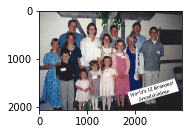

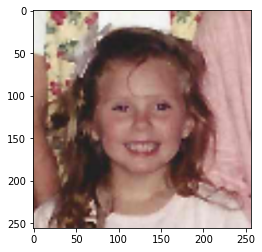

resnet prediction:
This is Mallory
Top 3 names: ['Mallory', 'Raven-Samone', 'Sanchit']

inception prediction:
This is Mallory
Top 3 names: ['Mallory', 'Sanchit', 'Raven-Samone']



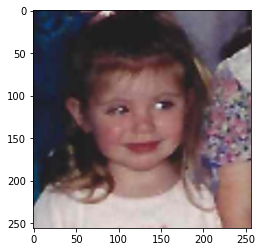

resnet prediction:
This is Mallory
Top 3 names: ['Mallory', 'Sanchit', 'Raven-Samone']

inception prediction:
This is Mallory
Top 3 names: ['Mallory', 'Raven-Samone', 'Other']



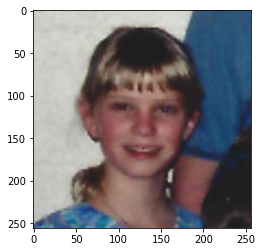

resnet prediction:
This is Mallory
Top 3 names: ['Mallory', 'Sanchit', 'Justin-Bieber']

inception prediction:
This is Justin-Bieber
Top 3 names: ['Justin-Bieber', 'Sanchit', 'Other']



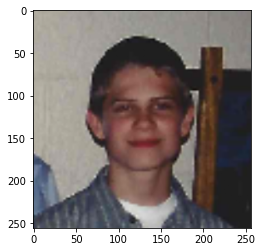

resnet prediction:
This is Sanchit
Top 3 names: ['Sanchit', 'Mallory', 'Other']

inception prediction:
This is Sanchit
Top 3 names: ['Sanchit', 'Mallory', 'Raven-Samone']



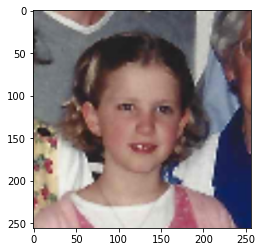

resnet prediction:
This is Sanchit
Top 3 names: ['Sanchit', 'Mallory', 'Justin-Bieber']

inception prediction:
This is Mallory
Top 3 names: ['Mallory', 'Sanchit', 'Other']



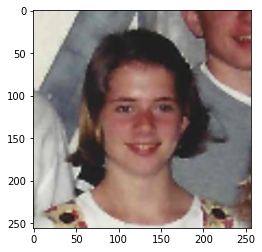

resnet prediction:
This is Sanchit
Top 3 names: ['Sanchit', 'Mallory', 'Other']

inception prediction:
This is Sanchit
Top 3 names: ['Sanchit', 'Mallory', 'Other']



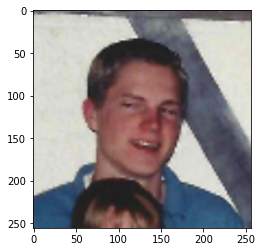

resnet prediction:
This is Sanchit
Top 3 names: ['Sanchit', 'Mallory', 'Other']

inception prediction:
This is Mallory
Top 3 names: ['Mallory', 'Sanchit', 'Justin-Bieber']



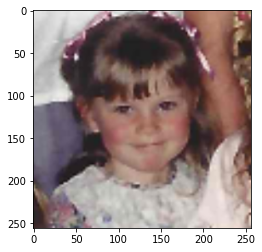

resnet prediction:
This is Sanchit
Top 3 names: ['Sanchit', 'Mallory', 'Justin-Bieber']

inception prediction:
This is Justin-Bieber
Top 3 names: ['Justin-Bieber', 'Other', 'Sanchit']



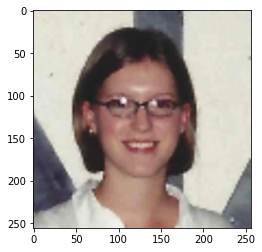

resnet prediction:
This is Other
Top 3 names: ['Other', 'Sanchit', 'Justin-Bieber']

inception prediction:
This is Other
Top 3 names: ['Other', 'Sanchit', 'Mallory']



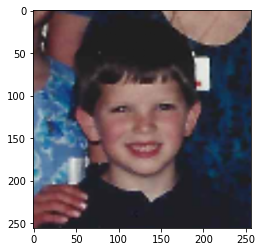

resnet prediction:
This is Mallory
Top 3 names: ['Mallory', 'Sanchit', 'Justin-Bieber']

inception prediction:
This is Mallory
Top 3 names: ['Mallory', 'Sanchit', 'Justin-Bieber']



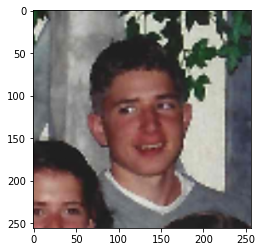

resnet prediction:
This is Mallory
Top 3 names: ['Mallory', 'Sanchit', 'Other']

inception prediction:
This is Sanchit
Top 3 names: ['Sanchit', 'Justin-Bieber', 'Other']



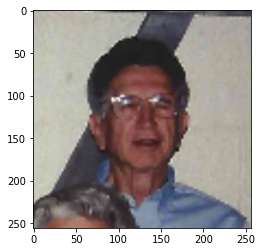

resnet prediction:
This is Sanchit
Top 3 names: ['Sanchit', 'Mallory', 'Other']

inception prediction:
This is Sanchit
Top 3 names: ['Sanchit', 'Other', 'Raven-Samone']



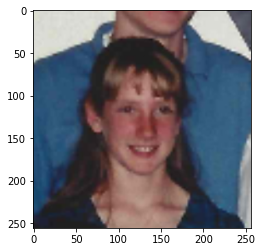

resnet prediction:
This is Mallory
Top 3 names: ['Mallory', 'Sanchit', 'Justin-Bieber']

inception prediction:
This is Justin-Bieber
Top 3 names: ['Justin-Bieber', 'Sanchit', 'Raven-Samone']



In [ ]:
image_path = PATH_455_GDRIVE + '/Mallory/uncropped/toddler/2002 .jpg'

url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/justin-bieber-and-hailey-bieber-attend-the-premiere-of-news-photo-1599217832.jpg?crop=0.769xw:0.491xh;0.139xw,0.00761xh&resize=980:*'

# include the 'https://' when the path is an url
# the two model:
#   resnet_model
#   inception_model
result = predict_pics(models, image_path, data['idx2class'], k=3)